In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from pyro.contrib.examples.bart import load_bart_od

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


In [3]:
T, _, _ = dataset["counts"].shape
data = (
    dataset["counts"][: T // (24 * 7) * 24 * 7].reshape(T // (24 * 7), -1).sum(-1).log()
)
data = data.unsqueeze(-1)
data = jnp.array(data)

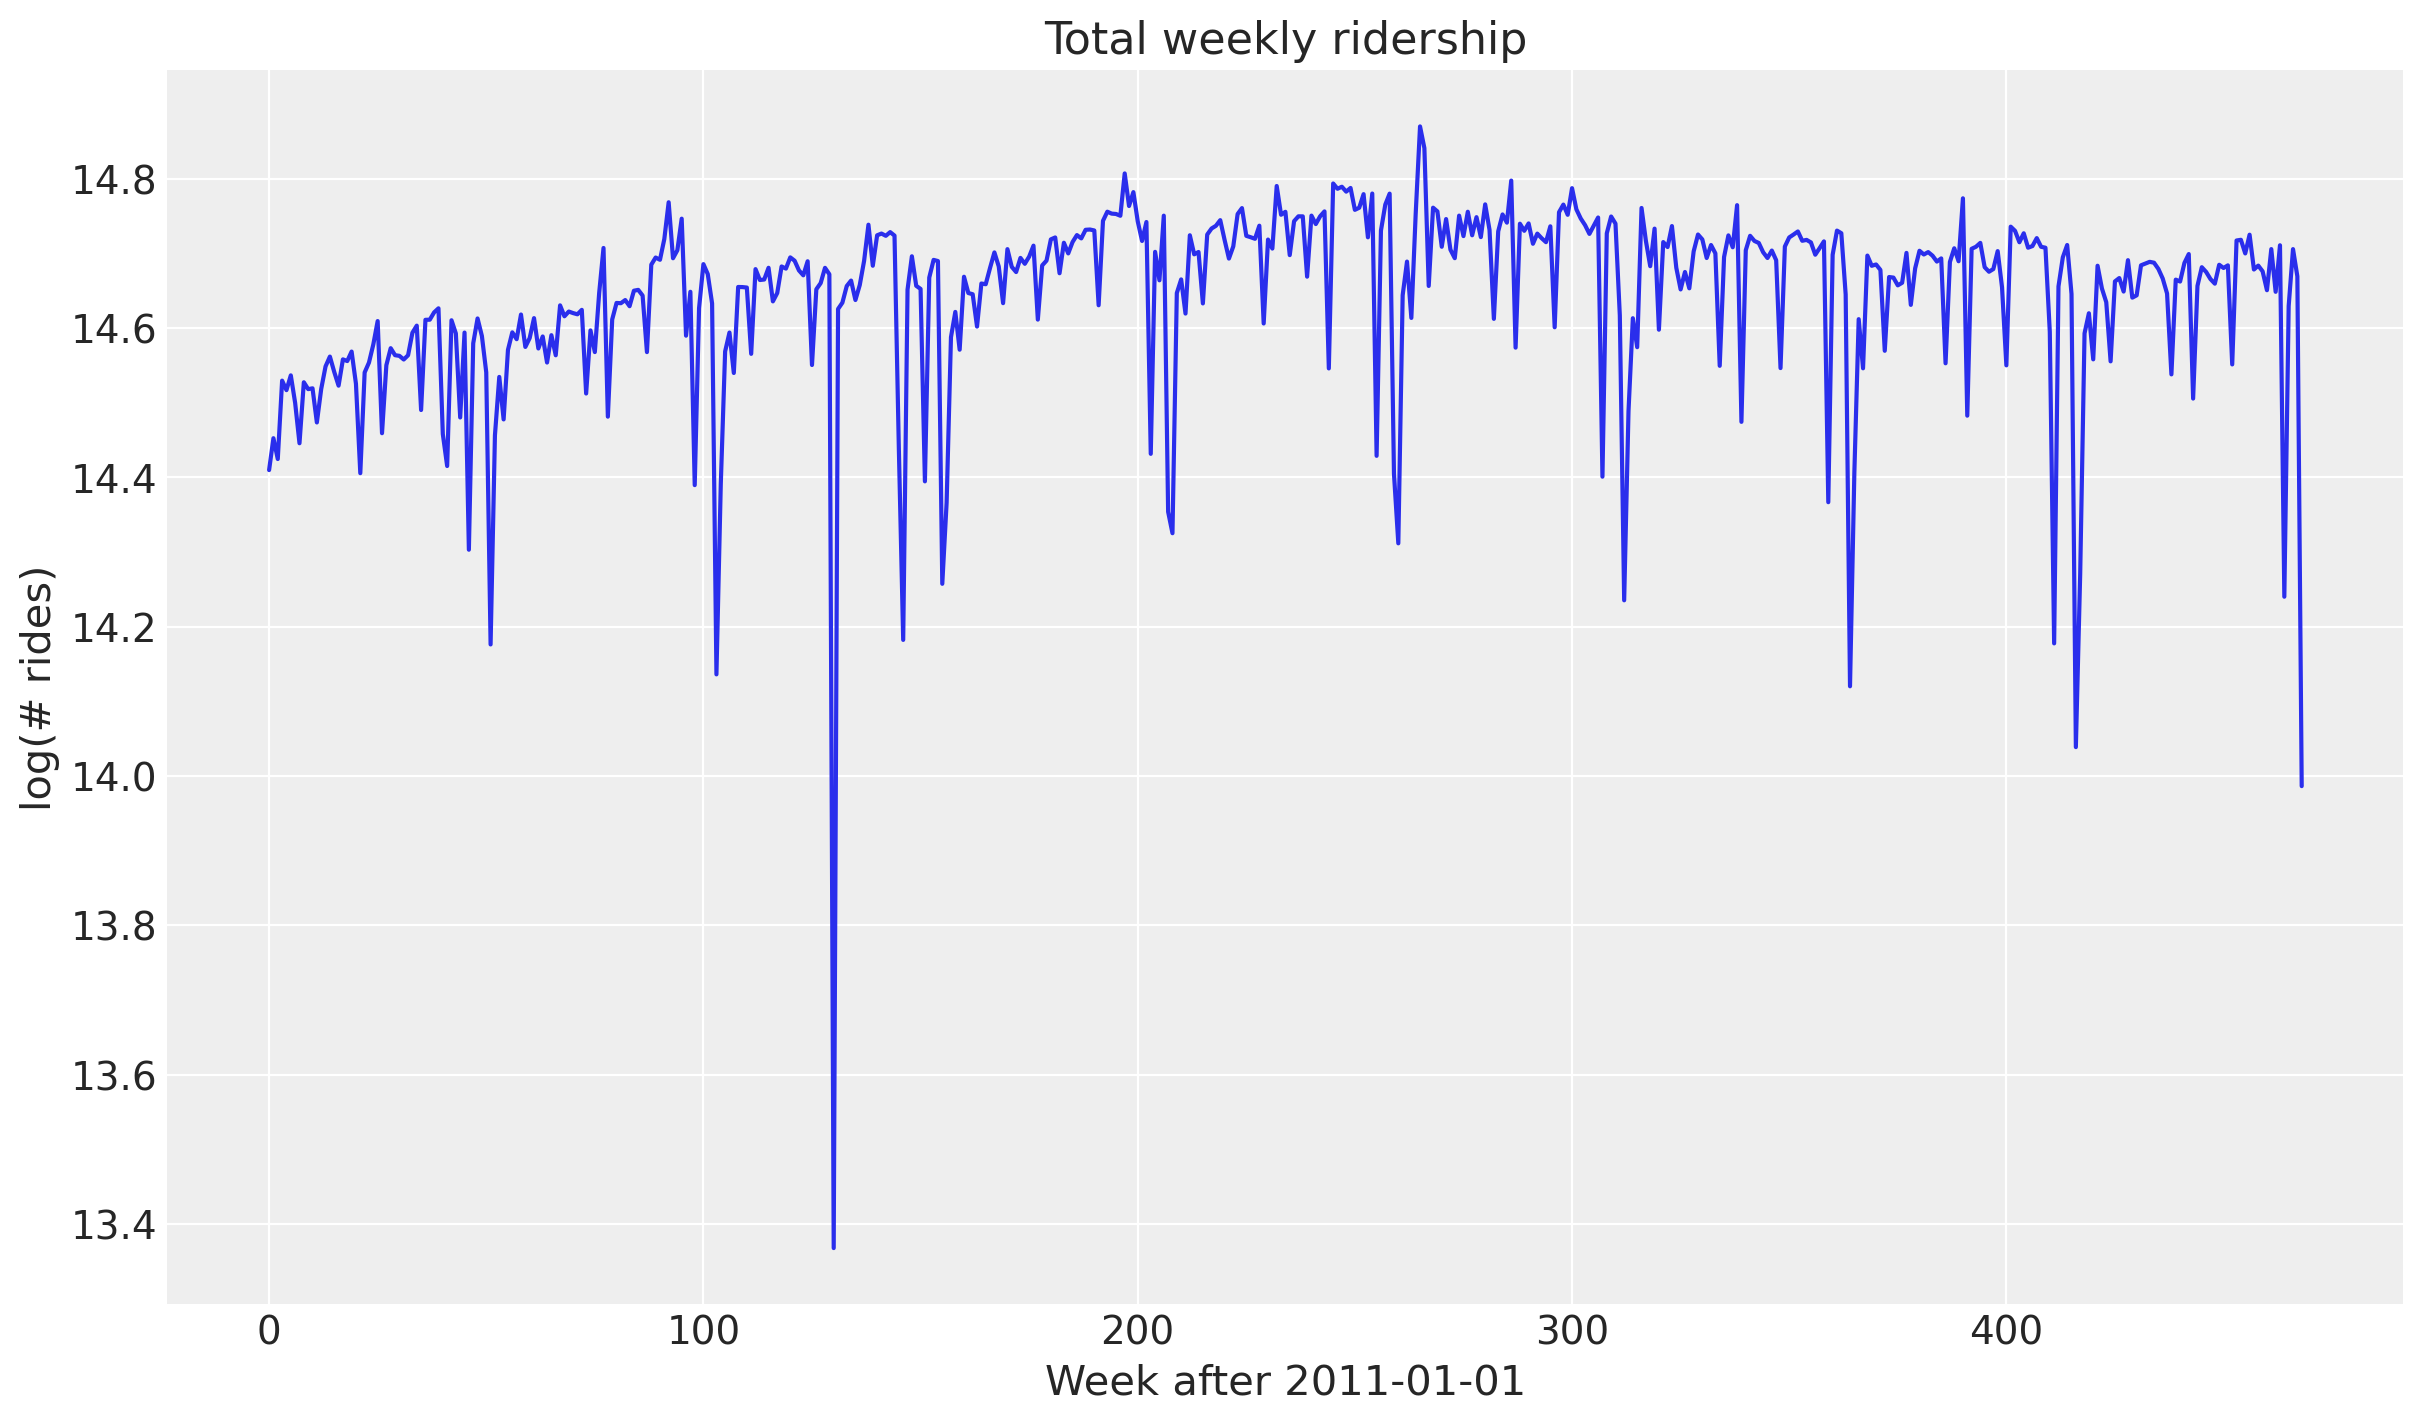

In [4]:
fig, ax = plt.subplots()
ax.plot(data)
ax.set(
    title="Total weekly ridership",
    ylabel="log(# rides)",
    xlabel="Week after 2011-01-01",
);

In [5]:
T0 = 0  # beginning
T2 = data.shape[-2]  # end
T1 = T2 - 52  # train/test split

data_train = data[T0:T1].flatten()
data_test = data[T1:T2].flatten()

time = jnp.arange(float(T2)) / 365
time_train = time[:T1]
time_test = time[T1:T2]

print(f"data_train shape: {data_train.shape}")
print(f"data_test shape: {data_test.shape}")

print(f"time_train shape: {time_train.shape}")
print(f"time_test shape: {time_test.shape}")

data_train shape: (417,)
data_test shape: (52,)
time_train shape: (417,)
time_test shape: (52,)


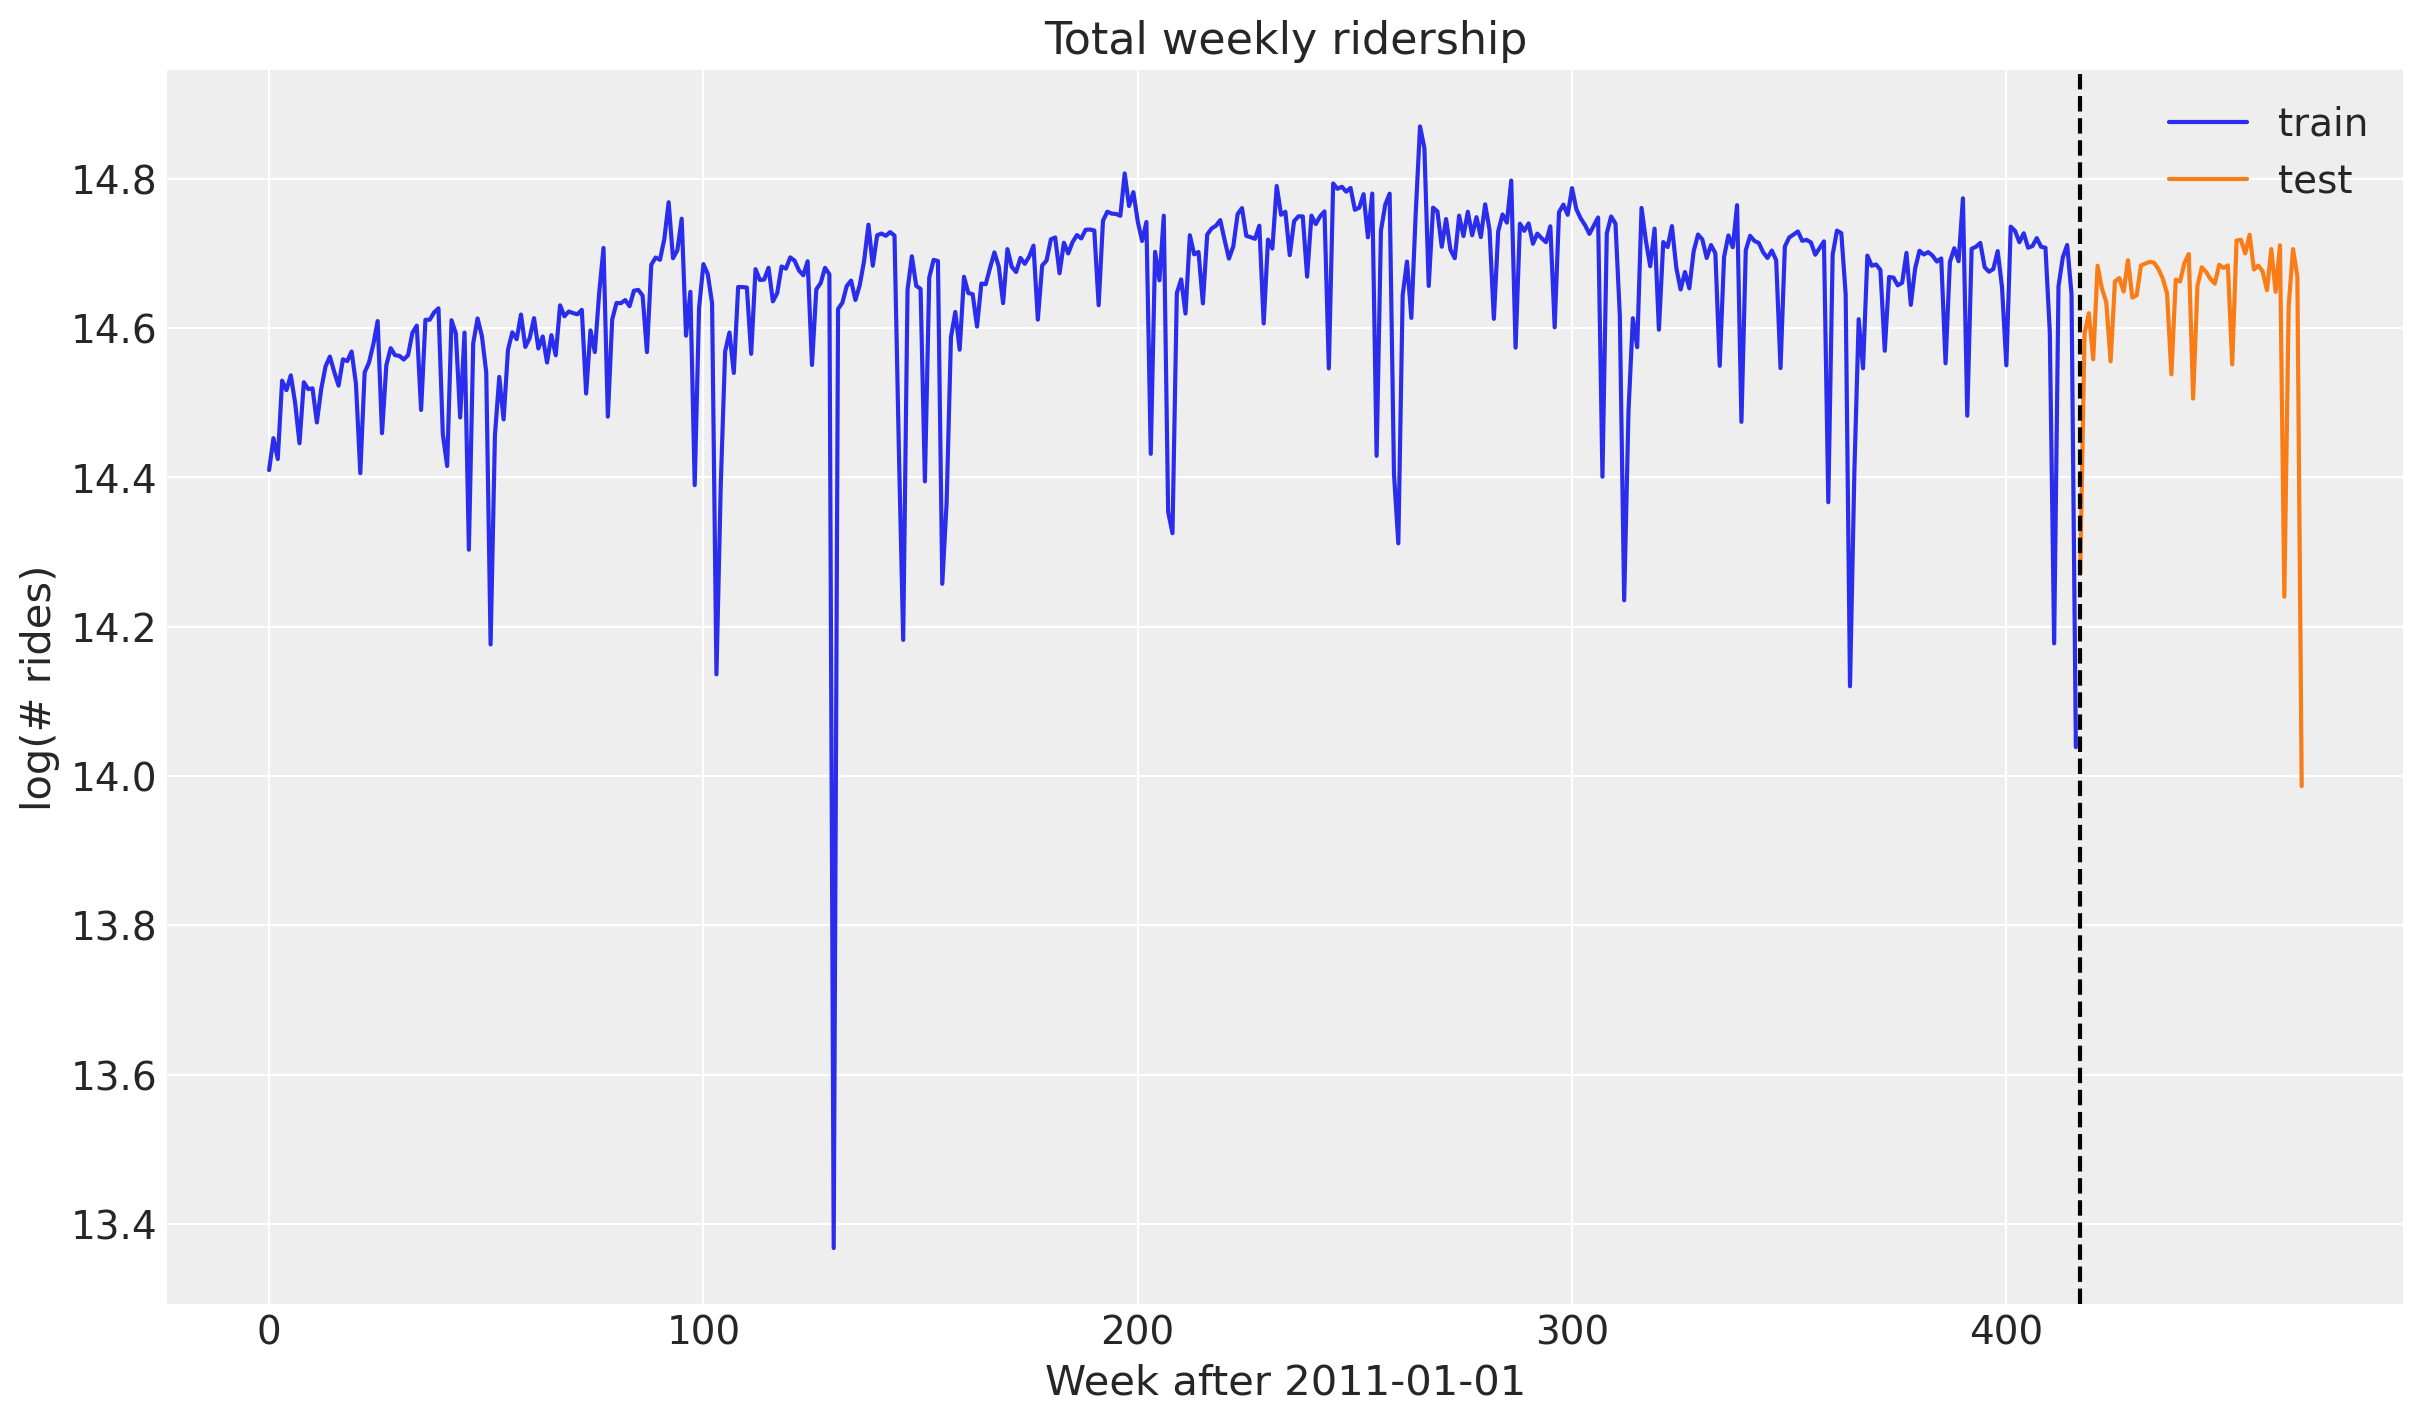

In [6]:
fig, ax = plt.subplots()
ax.plot(jnp.arange(T1), data_train, label="train")
ax.plot(jnp.arange(T1, T2), data_test, label="test")
ax.axvline(T1, c="black", linestyle="--")
ax.legend()
ax.set(
    title="Total weekly ridership",
    ylabel="log(# rides)",
    xlabel="Week after 2011-01-01",
);

In [7]:
def model(time, y=None):
    n = time.shape[0]
    bias = numpyro.sample("bias", dist.Normal(loc=0, scale=10))
    weight = numpyro.sample("weight", dist.Normal(loc=0, scale=0.1))
    sigma = numpyro.sample("sigma", dist.LogNormal(loc=-5, scale=5))

    mu = bias + weight * time

    with numpyro.plate("data", n):
        numpyro.sample("obs", dist.Normal(loc=mu, scale=sigma), obs=y)

100%|██████████| 15000/15000 [00:01<00:00, 9490.38it/s, init loss: 3333.3867, avg. loss [14251-15000]: -251.4361] 


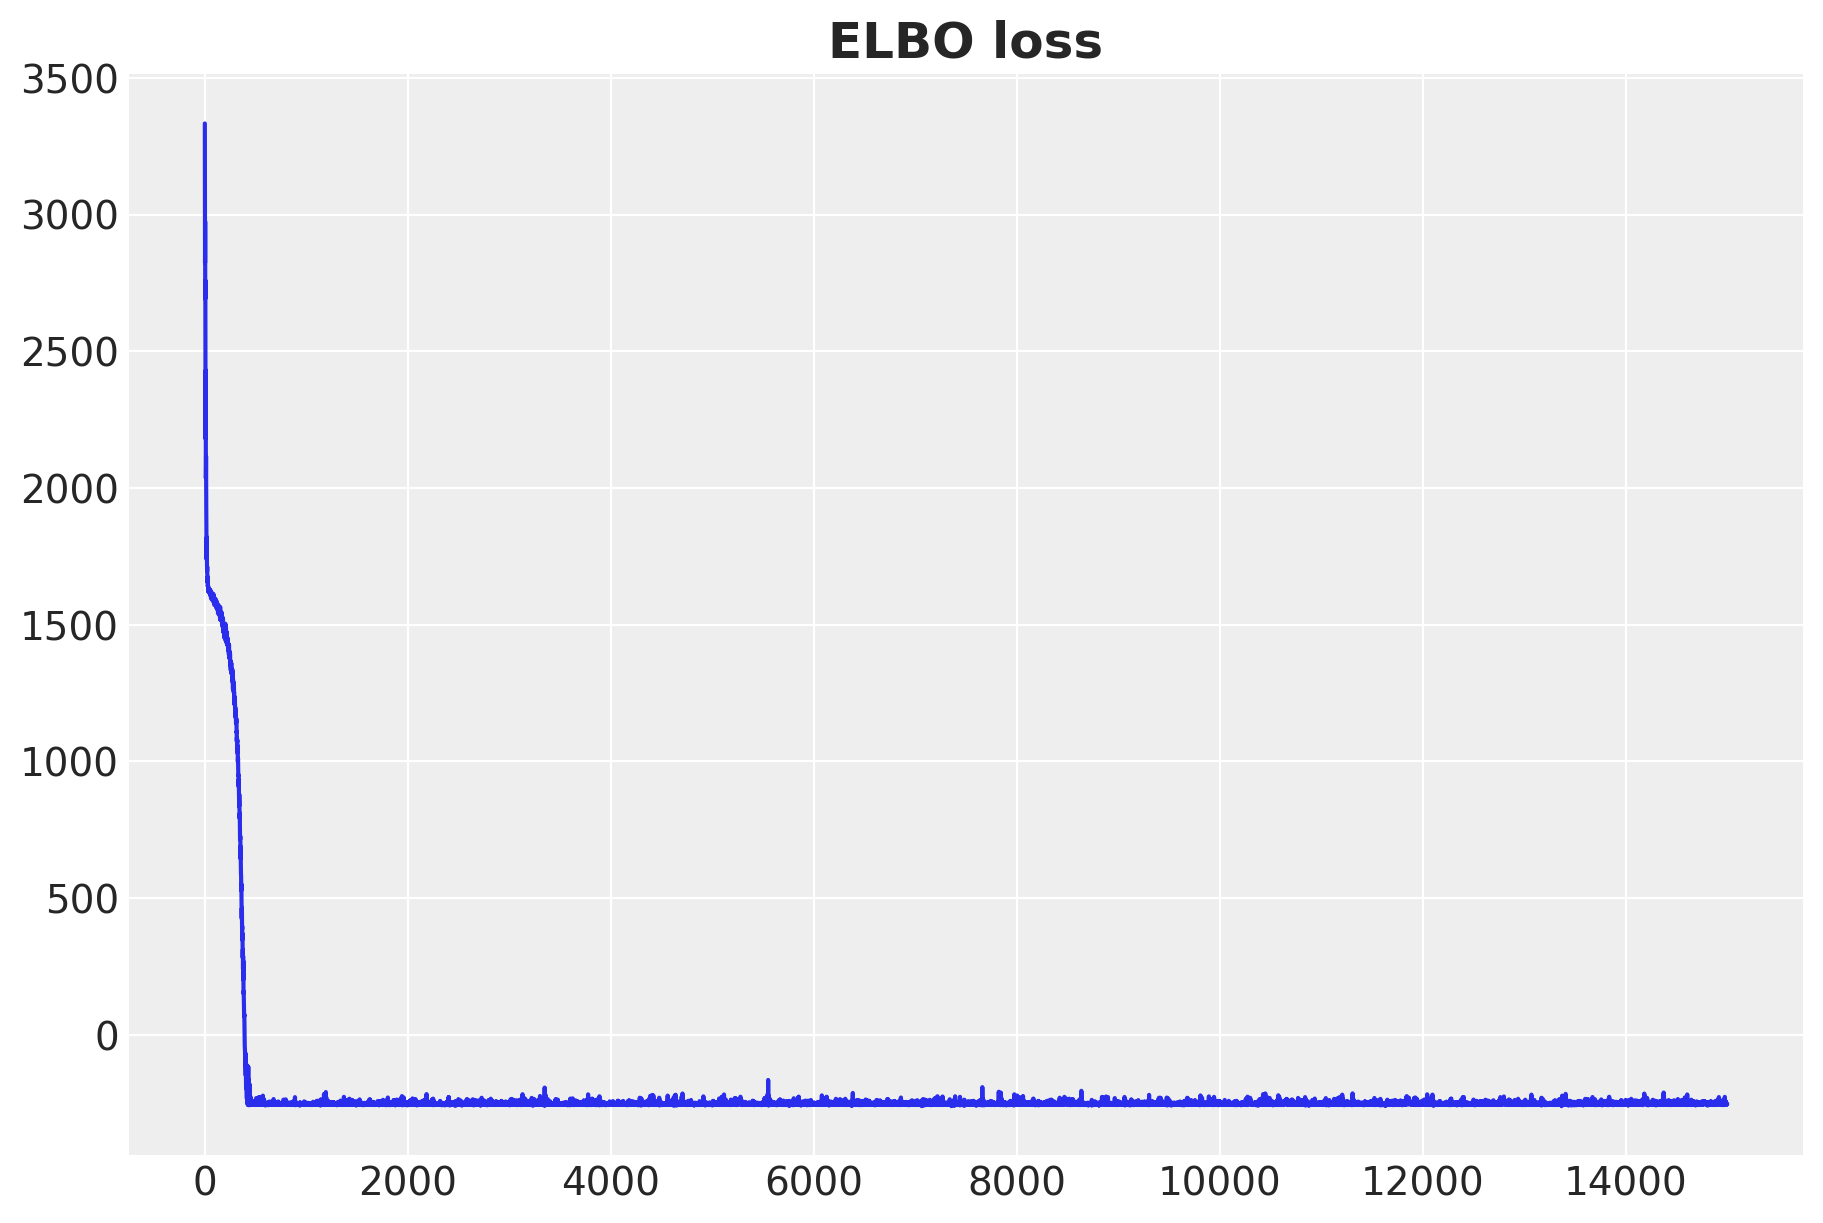

In [8]:
guide = AutoNormal(model)
optimizer = numpyro.optim.Adam(step_size=0.05)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
num_steps = 15_000

rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(
    rng_subkey,
    num_steps,
    time_train,
    data_train,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

In [9]:
svi_posterior_predictive = Predictive(
    model=model,
    guide=guide,
    params=svi_result.params,
    num_samples=4_000,
)

In [10]:
rng_key, rng_subkey = random.split(rng_key)

idata_train = az.from_dict(
    posterior_predictive={
        k: jnp.expand_dims(a=jnp.asarray(v), axis=0)
        for k, v in svi_posterior_predictive(rng_subkey, time_train).items()
    },
    coords={"time_train": time_train},
    dims={"obs": ["time_train"]},
)

idata_test = az.from_dict(
    posterior_predictive={
        k: jnp.expand_dims(a=jnp.asarray(v), axis=0)
        for k, v in svi_posterior_predictive(rng_subkey, time_test).items()
    },
    coords={"time_test": time_test},
    dims={"obs": ["time_test"]},
)

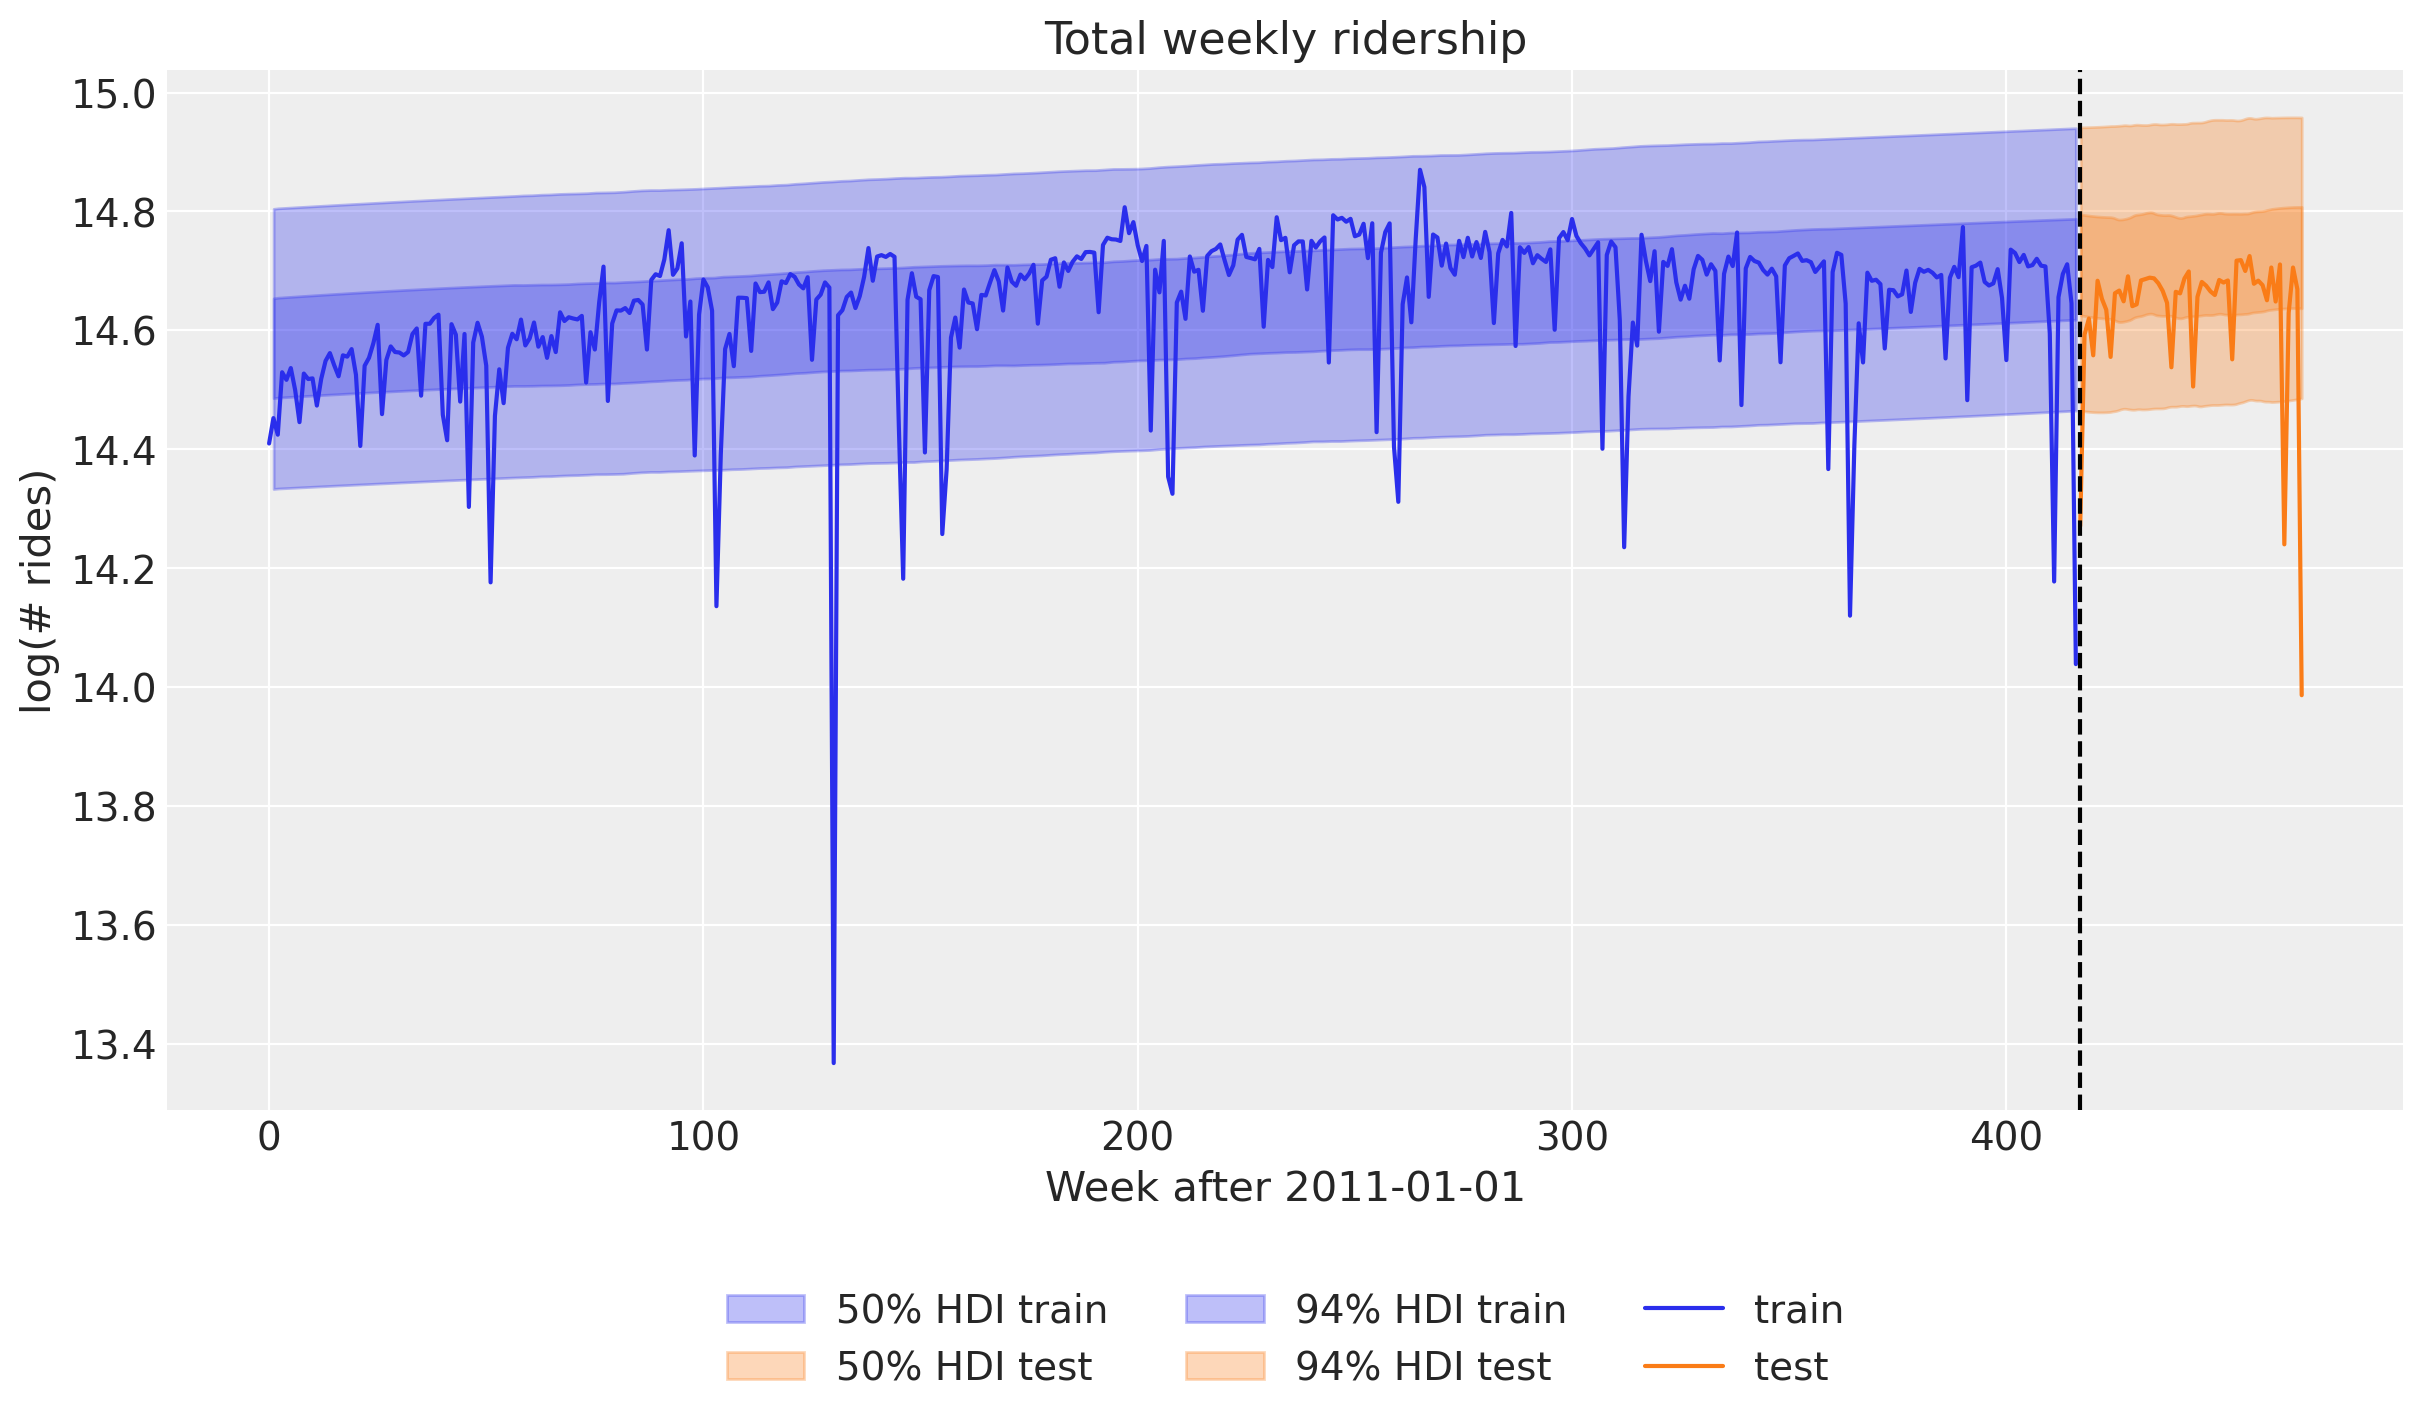

In [11]:
fig, ax = plt.subplots()

for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        jnp.arange(T1),
        idata_train["posterior_predictive"]["obs"],
        hdi_prob=hdi_prob,
        color="C0",
        fill_kwargs={
            "alpha": 0.3,
            "label": f"{hdi_prob*100:.0f}% HDI train",
        },
        ax=ax,
    )
    az.plot_hdi(
        jnp.arange(T1, T2),
        idata_test["posterior_predictive"]["obs"],
        hdi_prob=hdi_prob,
        color="C1",
        fill_kwargs={
            "alpha": 0.3,
            "label": f"{hdi_prob*100:.0f}% HDI test",
        },
        ax=ax,
    )

ax.plot(jnp.arange(T1), data_train, label="train")
ax.plot(jnp.arange(T1, T2), data_test, label="test")
ax.axvline(T1, c="black", linestyle="--")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)
ax.set(
    title="Total weekly ridership",
    ylabel="log(# rides)",
    xlabel="Week after 2011-01-01",
);

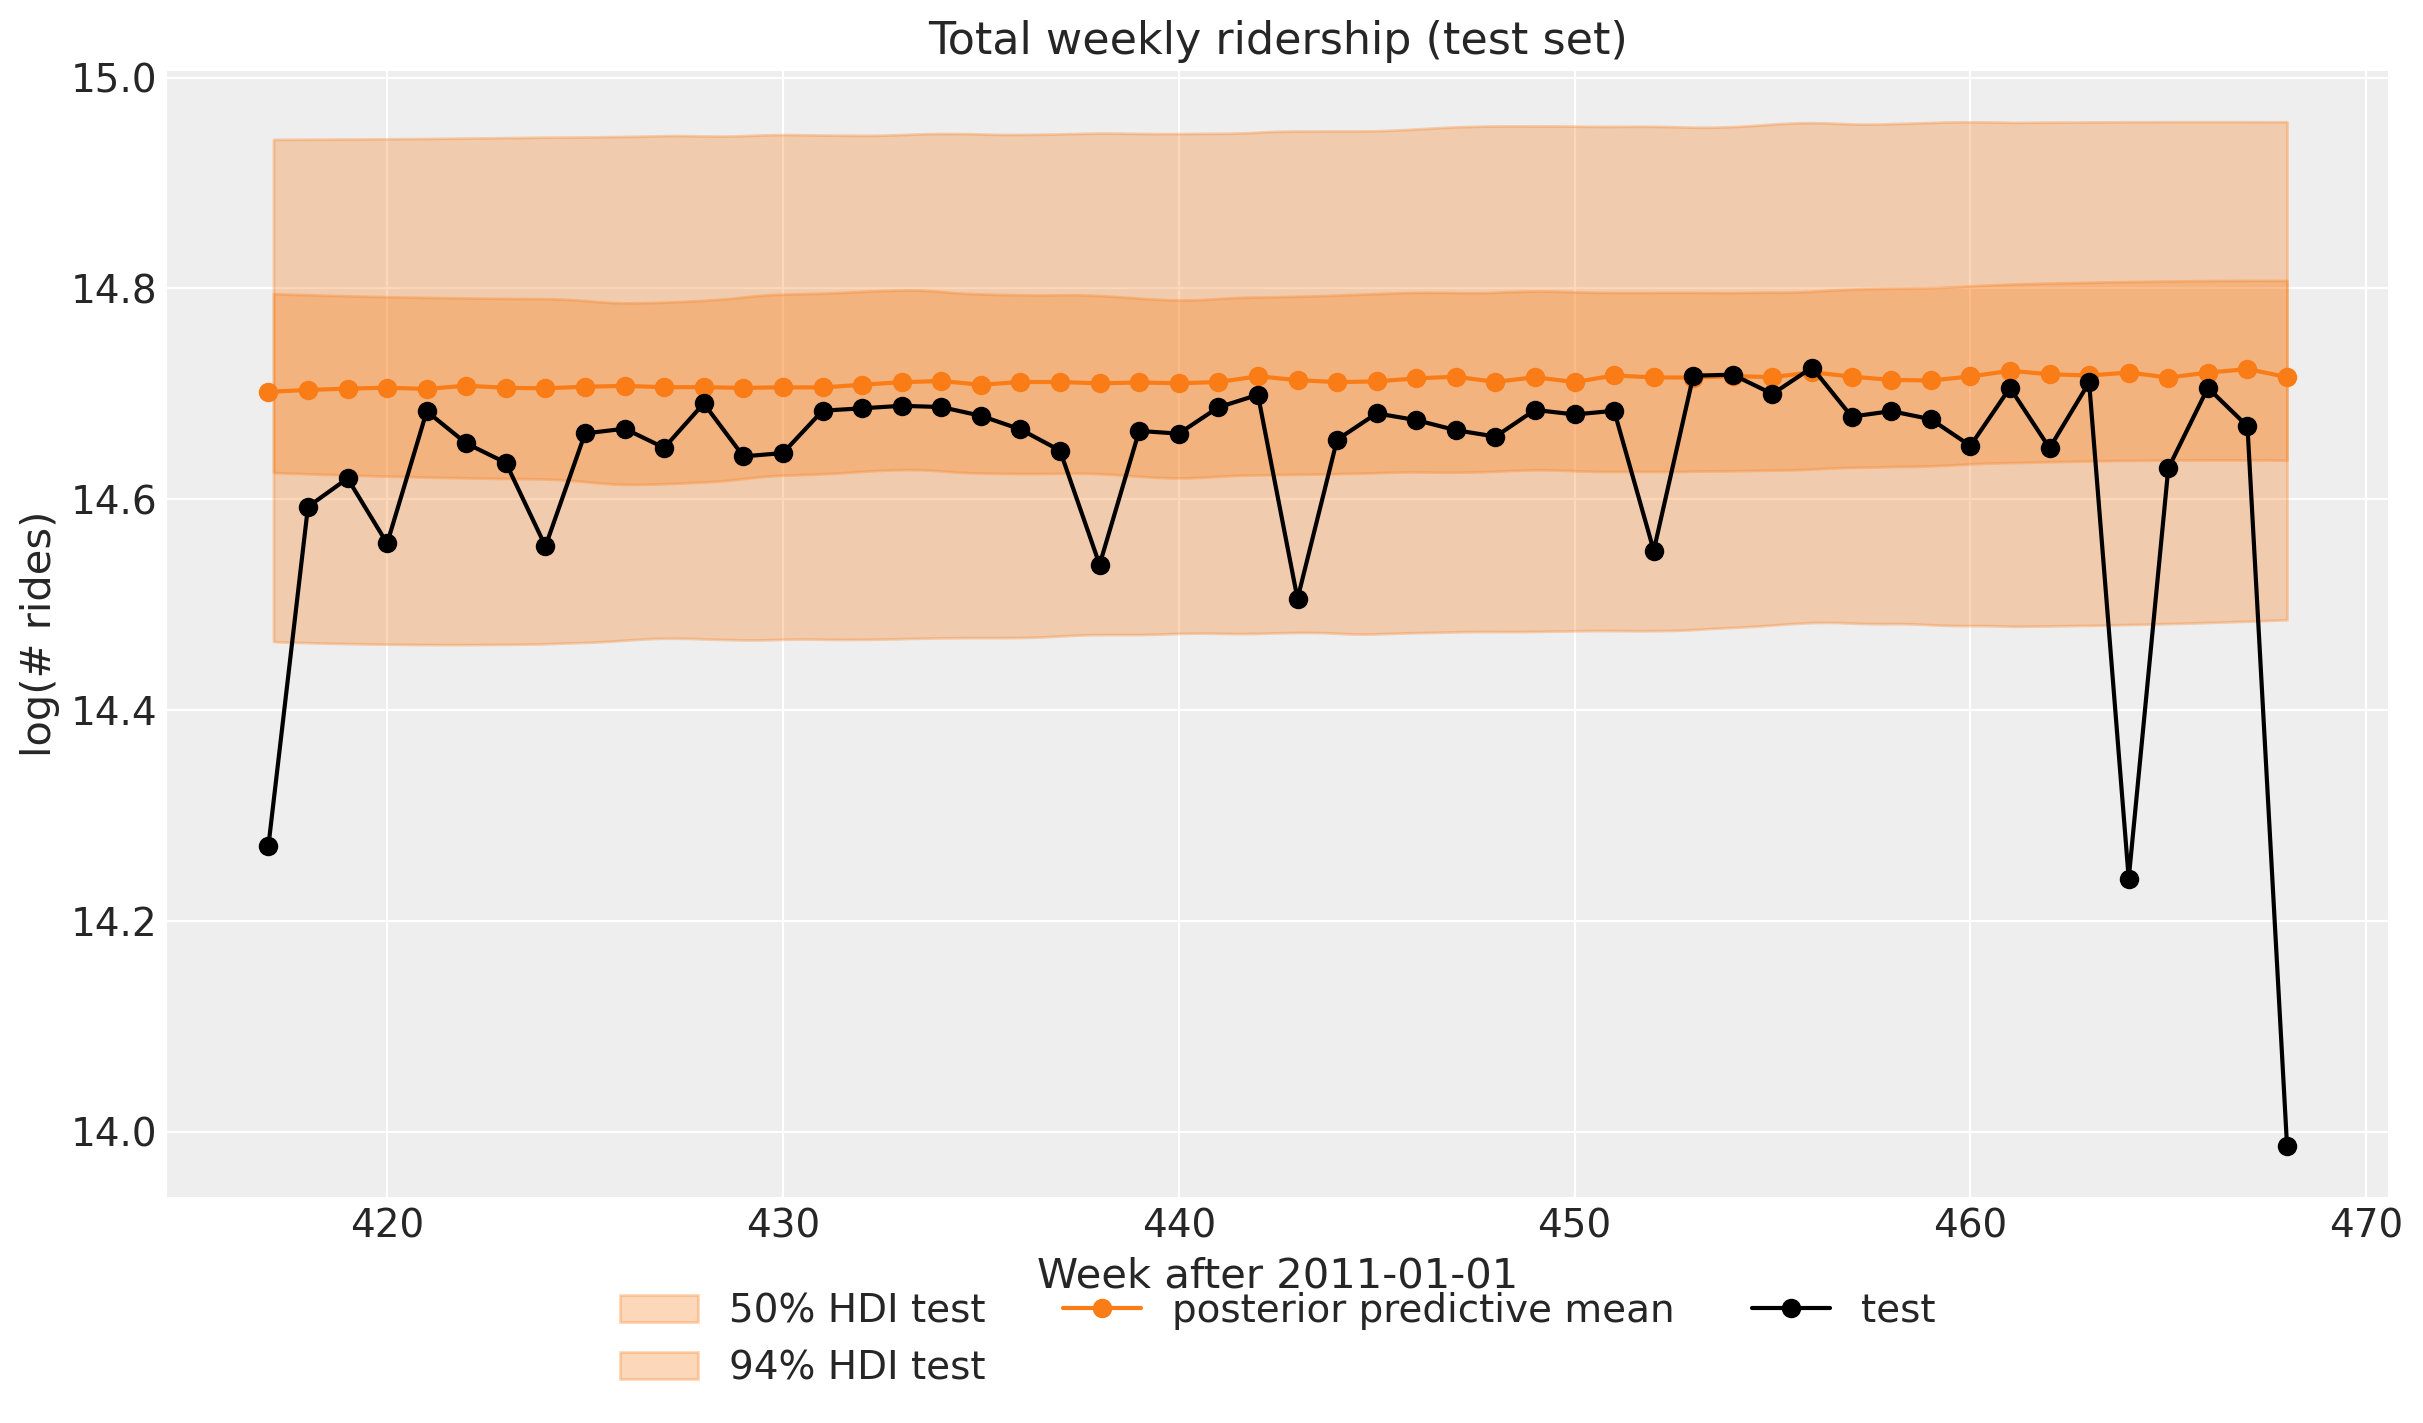

In [21]:
fig, ax = plt.subplots()

for hdi_prob in [0.50, 0.94]:
    az.plot_hdi(
        jnp.arange(T1, T2),
        idata_test["posterior_predictive"]["obs"],
        hdi_prob=hdi_prob,
        color="C1",
        fill_kwargs={
            "alpha": 0.3,
            "label": f"{hdi_prob*100:.0f}% HDI test",
        },
        ax=ax,
    )

ax.plot(
    jnp.arange(T1, T2),
    idata_test["posterior_predictive"]["obs"].mean(dim=("chain", "draw")),
    marker="o",
    color="C1",
    label="posterior predictive mean",
)
ax.plot(jnp.arange(T1, T2), data_test, marker="o", color="black", label="test")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=3)
ax.set(
    title="Total weekly ridership (test set)",
    ylabel="log(# rides)",
    xlabel="Week after 2011-01-01",
);